# DM-41734: document timing of AOS imSim simulations

We explore the timing information about a full-night of opSim sourced WFS simulations on USDF. 

https://jira.lsstcorp.org/browse/DM-41734

Load the opSim database, select visits from a single night. Query first for observations between two MJDs, eg. 61800 and 62500 to make the resulting table manageable in size.

In [1]:
import sqlite3
import numpy as np
import pandas as pd

columns = '*'
opsim_db_file = '/sdf/data/rubin/user/jchiang/imSim/rubin_sim_data/opsim_cadences/baseline_v3.2_10yrs.db'
query = (
    f"select {columns} from observations where "
         " 61800 < observationStartMJD "
         "and observationStartMJD < 62500 "
        )

with sqlite3.connect(opsim_db_file) as con:
    df0 = pd.read_sql(query, con)

print(len(df0))

384634


The database contains multiple columns, including 


     #   Column               Non-Null Count  Dtype  
    ---  ------               --------------  -----  
     0   observationId        60 non-null     int64  
     1   fieldRA              60 non-null     float64
     2   fieldDec             60 non-null     float64
     3   observationStartMJD  60 non-null     float64
     4   flush_by_mjd         60 non-null     float64
     5   visitExposureTime    60 non-null     float64
     6   filter               60 non-null     object 
     7   rotSkyPos            60 non-null     float64
     8   rotSkyPos_desired    60 non-null     float64
     9   numExposures         60 non-null     int64  
     10  airmass              60 non-null     float64
     11  seeingFwhm500        60 non-null     float64
     12  seeingFwhmEff        60 non-null     float64
     13  seeingFwhmGeom       60 non-null     float64
     14  skyBrightness        60 non-null     float64
     15  night                60 non-null     int64  
     16  slewTime             60 non-null     float64
     17  visitTime            60 non-null     float64
     18  slewDistance         60 non-null     float64
     19  fiveSigmaDepth       60 non-null     float64
     20  altitude             60 non-null     float64
     21  azimuth              60 non-null     float64
     22  paraAngle            60 non-null     float64
     23  cloud                60 non-null     float64
     24  moonAlt              60 non-null     float64
     25  sunAlt               60 non-null     float64
     26  note                 60 non-null     object 
     27  target               60 non-null     object 
     28  fieldId              60 non-null     int64  
     29  proposalId           60 non-null     int64  
     30  block_id             60 non-null     int64  
     31  observationStartLST  60 non-null     float64
     32  rotTelPos            60 non-null     float64
     33  rotTelPos_backup     60 non-null     float64
     34  moonAz               60 non-null     float64
     35  sunAz                60 non-null     float64
     36  sunRA                60 non-null     float64
     37  sunDec               60 non-null     float64
     38  moonRA               60 non-null     float64
     39  moonDec              60 non-null     float64
     40  moonDistance         60 non-null     float64
     41  solarElong           60 non-null     float64
     42  moonPhase            60 non-null     float64
     43  cummTelAz            60 non-null     float64
     44  scripted_id          60 non-null     int64 


Of particular interest is `night` which groups all visits that correspond to a particular observing night. 

Select all visits from a given night:

In [2]:
nightId = 1206
mask = df0['night'].values == nightId
firstVisit = min(df0['observationId'][mask])
lastVisit = max(df0['observationId'][mask])
visits = df0['observationId'][mask].values
Nvisits = len(visits)
print(f'Night {nightId} contains {Nvisits} visits. The first visit id is {firstVisit}, and last visit is {lastVisit}')


Night 1206 contains 957 visits. The first visit id is 739408, and last visit is 740364


Store this subset of opSim database as a table:

In [3]:
from astropy.table import Table
df0_selected_night = Table.from_pandas(df0[mask])
df0_selected_night.write('opsim_night_1206_all_cols.txt', format='ascii', overwrite=True)

All simulations were all run with slurm scripts

In [ ]:
#import stacking
import os 

nodes=1
thrs= 100 # for some jobs 5 hrs this is totally insufficient! 
partition='milano'
mem=100 # G, instead of 50G
ncpu_task = 64  # instead of 8 , since I set OMP_NUM_THREADS=4 , and there are 
# output.nproc: 8 , output.nfiles: 8 

# For these I want to make sure I don't want to run into time limit...
# So submit these in a staggered fashion, 
# but with more memory, and more time limit than before 

def write_to_file(out_file, content):
    with open(out_file, "w") as output:
        for line in content:
            output.write(line)
            
# why was it so much quicket 
for visit in visits_to_test:# visits_to_resubmit:# visits_not_done: # 408 and 409 already there ... 
    visit = int(visit)
    print(visit)
    path_cwd = '/sdf/data/rubin/shared/scichris/DM-41019/'
    slurm_file = os.path.join(path_cwd, f'runSlurm9_wfs-{visit}.sl')
    
    # the instance catalog to use ... 
    path_to_imsim_yaml = os.path.join(path_cwd,'imsim-run-WFS.yaml')
    cmd = f"galsim {path_to_imsim_yaml} input.opsim_data.visit={visit}"
    
    path_to_slurm_log = os.path.join(path_cwd, f'{visit}_1.out')
    content = ['#!/bin/bash -l \n',
              f'#SBATCH --partition {partition} \n',
              '#SBATCH --account rubin:developers \n',
              f'#SBATCH --nodes {nodes} \n',
              f'#SBATCH --mem={mem}G \n',
              f'#SBATCH --cpus-per-task={ncpu_task}\n',
              f'#SBATCH -t {thrs}:00:00 \n', 
              f'#SBATCH --job-name v{visit} \n'
              f'#SBATCH --output={path_to_slurm_log} \n',
                'echo "starting at `date` on `hostname`" \n',
                "pwd \n",
                 cmd,
                '\n echo "ended at `date` on `hostname`" \n',
              ]
    write_to_file(slurm_file, content)

The `galsim`  yaml contains  `max_flux: 1e7`. This means that stars only up to about 13th magnitude were simulated.  

In [25]:
#visits

In [4]:
import numpy as np
visits = np.loadtxt('opsim_visits_night_1206.txt')
print(f'There are {len(visits)} visits in that night ')



There are 957 visits in that night 


Take runtime from galsim info log files. We created `.out`, `_.out` and `_1.out` files, that designate running with different `slurm` settings above. All visits were simulated with standard setting of OMP_NUM_THREADS (=1), and --cpus-per-task=8 (to match nfiles and nproc) - blue color below.
A subset of 44 visits were also re-simulated with OMP_NUM_THREADS=4, --cpus-per-task=32 (orange), as well as  OMP_NUM_THREADS=8, --cpus-per-task=64 (red), to test whether changing these settings decreases the runtime. 

In [42]:
import os
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41019/'
out_files = [file for file in os.listdir(path_cwd) if file.endswith('.out')]


# find out what is the content and length of all out files 
file_content = {}
file_length = {}

for i in range(len(out_files)):
    fname = out_files[i]
    path_to_file = os.path.join(path_cwd, fname)

    with open(path_to_file) as f:
        allLines = f.readlines()
    file_content[fname] = allLines
    file_length[fname] = len(allLines)
     
# check only those that seem to be long enough (longer than eg. 700 lines)
# and then check if any  the lines  in the file seems to contain the 
# summary statement that tells us how much time it took ...

# record which ones have actually finished as opposed to not finished ... 
# basically those that have the `Total time` have finished, and everything else has not ... 
file_runtime_sec = {}
visits_done = []# float(fname[:6]) for fname in file_runtime_sec.keys()]
visits_runtime = []
outfile_name = []
for fname  in file_length.keys():
    length = file_length[fname]
    if length>300:
        
        for content in file_content[fname]:
            if content.startswith('Total time for '):
                #print(fname, length)
                #print(content)
                a=content
                runtime = float(a.split()[-2])
                file_runtime_sec[fname] = runtime
                visits_done.append(float(fname[:6]))
                visits_runtime.append(runtime)
                outfile_name.append(fname)
            #if content.startswith('psycopg2.OperationalError'):
            #  print(fname, length)
            #  print(content)
        #print(file_content[fname][-3:])

In [33]:
increase1_visits = [file for file in out_files if file.endswith('_.out')]
increase2_visits = [file for file in out_files if file.endswith('_1.out')]

In [60]:
len(increase1_visits)

530

In [38]:
len(increase2_visits)

44

In [21]:
len(visits_done)

989

In [8]:
len(np.unique(visits_done))

957

In [9]:
visits_not_done = visits[~np.in1d(visits, visits_done)]
print(len(visits_not_done))

0


This means that indeed all visits got successfully simulated, at least based on the log files. 

In [44]:
#outfile_name

In [45]:
from astropy.table import Table
visit_time_table = Table(data=[visits_done, visits_runtime, outfile_name], names=['visit', 'runtime', 'outfile'])

The content for the 44 visits of the _.out is trash, and for these 44 visits there's new _1.out , with `OMP_NUM_THREADS=8` and `--cpus-per-task=64`... 


In [40]:
len(visit_time_table)

989

In [46]:
visit_time_table[:10]

visit,runtime,outfile
float64,float64,str17
740103.0,3389.634337,740103.out
739961.0,3309.216794,739961_.out
740350.0,900.701982,740350_1.out
739539.0,8649.665286,739539.out
740148.0,2007.822759,740148_.out
739645.0,77290.338465,739645_.out
739584.0,2737.415792,739584_.out
739832.0,2238.894855,739832_.out
739860.0,2193.983795,739860_.out


Add number of objects from centroid files (this cell takes a minute to run). We check only one detector : `R00_SW0`, so the number of objects is per single wavefront sensor, i.e. 2000x4000 px. Given the pixel scale of  0.2 arcsec/pixel, this gives the approximate area  covered by each half-sensor of of 400x800 sq. arcsec, i.e. (400/3600)x(800/3600) sq. degrees, which gives (1/9)*(2/9) sq deg., i.e. 2/81 sq.deg == 0.0247 sq. deg. This is the value used to convert the source count per-sensor to per-sq-degree.

In [48]:
import glob
number_objects = []
for visit in visit_time_table['visit']:
    visit_int = int(visit)
    root_dir = '/sdf/group/rubin/shared/scichris/DM-41019/'
    out_dir = f'output_all_WFS_mult_visits/00{visit_int}/'
    fname = f'centroid_*-R00_SW0-det191.txt.gz'
    pattern = f'{root_dir}{out_dir}{fname}'
    fpath = glob.glob(pattern)[0]
    centroid = Table.read(fpath, format='csv',delimiter=' ',
          names=['object_id','ra','dec','x','y','nominal_flux','phot_flux','fft_flux','realized_flux'])
    #print(visit_int, len(centroid))
    number_objects.append(len(centroid))

visit_time_table['nobj_R00_SW0'] = number_objects

In [50]:
visit_time_table[:5]

visit,runtime,outfile,nobj_R00_SW0
float64,float64,str17,int64
740103.0,3389.634337,740103.out,144
739961.0,3309.216794,739961_.out,206
740350.0,900.701982,740350_1.out,50
739539.0,8649.665286,739539.out,293
740148.0,2007.822759,740148_.out,100


Text(0.5, 1.0, 'WFS opSim-imSim night 1206')

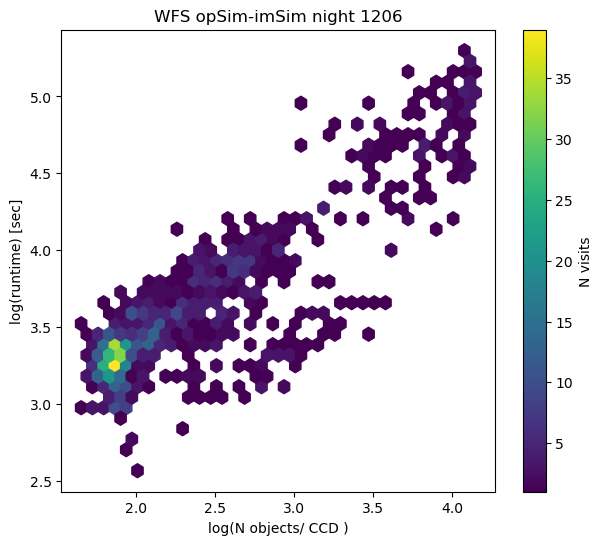

In [73]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots(1,1,figsize=(7.,6))
im = ax.hexbin(np.log10(visit_time_table['nobj_R00_SW0']), np.log10(visit_time_table['runtime']),
          mincnt=1, gridsize=35)
ax.set_ylabel('log(runtime) [sec]')
ax.set_xlabel('log(N objects/ CCD )')
fig.colorbar(im, label='N visits')
plt.title('WFS opSim-imSim night 1206')


Text(0, 0.5, 'Visit count')

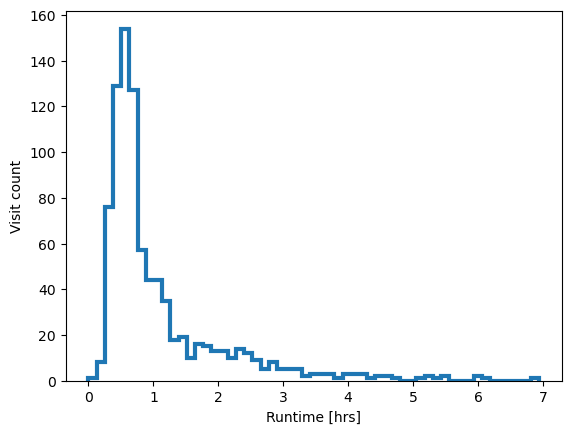

In [57]:
plt.hist(visit_time_table['runtime']/3600, bins=55, range=(0,25000/3600),histtype='step',
        lw=3)
plt.xlabel('Runtime [hrs]')
plt.ylabel('Visit count')

Also, tested the effect of setting `OMP_NUM_THREADS`.  Below:

* blue:  standard OMP_NUM_THREADS (=1), and --cpus-per-task=8 (to match nfiles and nproc).
* orange:  increased     OMP_NUM_THREADS=4, --cpus-per-task=32
* red: increased OMP_NUM_THREADS=8, --cpus-per-task=64
    
    
Orange and red are exactly the same visits.  Blue are other visits from the night.  


In [61]:
#  OMP_NUM_THREADS=4, --cpus-per-task=32 was run from script  runSlurm8_wfs
root_dir = '/sdf/group/rubin/shared/scichris/DM-41019/'
flist = [f  for f in os.listdir(root_dir) if f.startswith('runSlurm8_wfs') ]
visit_numbers = [float(fname.split('-')[1].split('.')[0]) for fname in flist]
select = np.in1d(visit_time_table['visit'], visit_numbers)

In [70]:
#  OMP_NUM_THREADS=8, --cpus-per-task=64 was saved as _1.out  
fnames_sel = [fname  for fname in visit_time_table['outfile'] if fname.endswith('_1.out')]
select2 = np.in1d(visit_time_table['outfile'], fnames_sel)


Text(0.5, 1.0, 'WFS opSim-imSim night 1206')

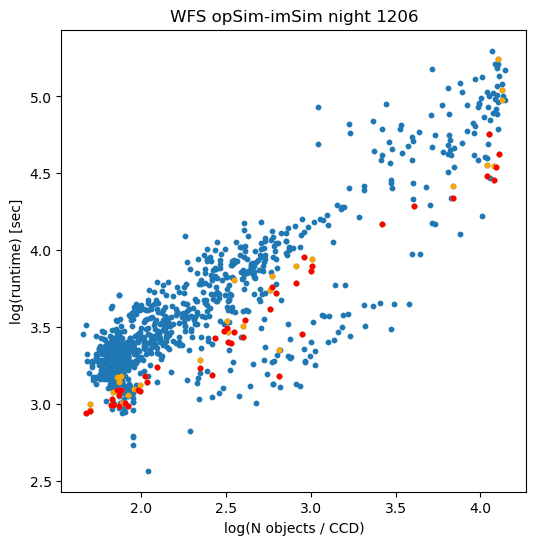

In [74]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots(1,1,figsize=(6.,6))
ax.scatter(np.log10(visit_time_table['nobj_R00_SW0']), np.log10(visit_time_table['runtime']),
         s=10)
ax.scatter(np.log10(visit_time_table['nobj_R00_SW0'][select]), np.log10(visit_time_table['runtime'][select]),
         s=10,c='orange')
ax.scatter(np.log10(visit_time_table['nobj_R00_SW0'][select2]), np.log10(visit_time_table['runtime'][select2]), 
         s=10, c='red')
ax.set_ylabel('log(runtime) [sec]')
ax.set_xlabel('log(N objects / CCD)')
plt.title('WFS opSim-imSim night 1206')

This shows a tentative linear relationship between execution time $t$ and the number of objects in  a CCD $N$ of a form  
$$
\log_{10}(t) = a*\log_{10}(N)+b
$$
or

$$
t = 10^{b} * N^{a}
$$
The number of objects per CCD can be also expressed as a number of sources  per sq.deg., given the approximate pixel scale:



fit: a=0.671, b=0.942


Text(0.5, 1.0, 'WFS opSim-imSim night 1206')

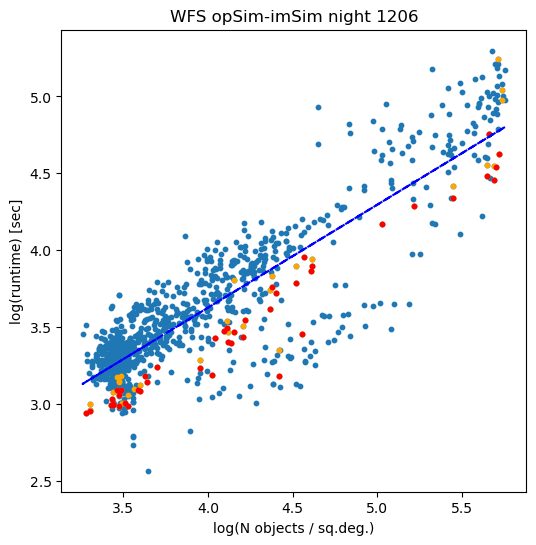

In [80]:
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x + b

xdata = np.log10(visit_time_table['nobj_R00_SW0']/area_per_ccd_sq_deg)
ydata = np.log10(visit_time_table['runtime'])
popt,pcov = curve_fit(func, xdata, ydata,)
                         
fig,ax=plt.subplots(1,1,figsize=(6.,6))
area_per_ccd_sq_deg =  0.0247
ax.scatter(np.log10(visit_time_table['nobj_R00_SW0']/area_per_ccd_sq_deg), np.log10(visit_time_table['runtime']),
         s=10)
ax.plot(xdata, func(xdata, *popt), '--',color='blue',label='fit')
print('fit: a=%5.3f, b=%5.3f' % tuple(popt))
ax.scatter(np.log10(visit_time_table['nobj_R00_SW0'][select]/area_per_ccd_sq_deg), np.log10(visit_time_table['runtime'][select]),
         s=10,c='orange')
ax.scatter(np.log10(visit_time_table['nobj_R00_SW0'][select2]/area_per_ccd_sq_deg), np.log10(visit_time_table['runtime'][select2]), 
         s=10, c='red')
ax.set_ylabel('log(runtime) [sec]')
ax.set_xlabel('log(N objects / sq.deg.)')
plt.title('WFS opSim-imSim night 1206')

The simple linear fit is 
$$
\log_{10}(t) = 0.671*\log_{10}(N)+0.942
$$

i.e. 

$$
t = 10^{0.942}*N^{0.671} = 8.749 * N^{0.671} \mathrm{[sec]}
$$